<a href="https://colab.research.google.com/github/Amna1701/alfaisalx-medmnist-challenge/blob/main/notebooks/AlfaisalX_Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 – CNN Classification on PneumoniaMNIST

This notebook implements a lightweight convolutional neural network (CNN)
for binary classification of chest X-ray images (Normal vs Pneumonia)
using the MedMNIST v2 PneumoniaMNIST dataset.

The implementation runs on CPU and reproduces evaluation metrics,
saves training curves, confusion matrix, ROC curve, failure cases,
and Grad-CAM visualizations under:

reports/task1/

## Environment Setup

In [1]:
!pip install medmnist torch torchvision scikit-learn tqdm faiss-cpu timm transformers -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 3.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from medmnist import PneumoniaMNIST
from torchvision import transforms

# Basic transforms (no augmentation yet)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load splits
train_ds = PneumoniaMNIST(split="train", download=True, transform=transform)
val_ds   = PneumoniaMNIST(split="val",   download=True, transform=transform)
test_ds  = PneumoniaMNIST(split="test",  download=True, transform=transform)

print("Train:", len(train_ds), " Val:", len(val_ds), " Test:", len(test_ds))
print("Example item shapes:")
x, y = train_ds[0]
print("Image tensor shape:", x.shape, " Label:", y, " Label type:", type(y))

100%|██████████| 4.17M/4.17M [00:00<00:00, 5.39MB/s]


Train: 4708  Val: 524  Test: 624
Example item shapes:
Image tensor shape: torch.Size([1, 28, 28])  Label: [1]  Label type: <class 'numpy.ndarray'>


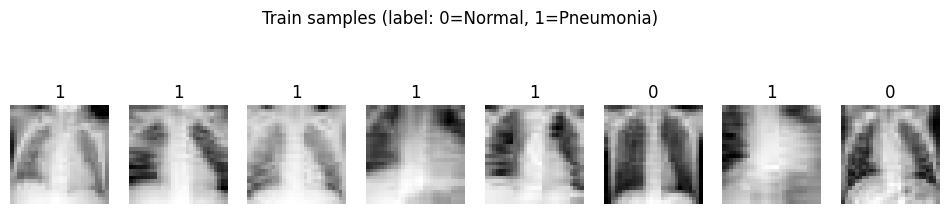

In [3]:
def show_samples(dataset, n=8, title="Samples"):
    plt.figure(figsize=(12, 3))
    for i in range(n):
        x, y = dataset[i]
        img = x.squeeze(0).numpy()  # (28,28)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap="gray")
        plt.title(int(y[0]))
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(train_ds, n=8, title="Train samples (label: 0=Normal, 1=Pneumonia)")

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
from medmnist import PneumoniaMNIST
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
train_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=7, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

train_ds = PneumoniaMNIST(split="train", download=True, transform=train_tf)
val_ds   = PneumoniaMNIST(split="val",   download=True, transform=test_tf)
test_ds  = PneumoniaMNIST(split="test",  download=True, transform=test_tf)

batch_size = 128
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2)

len(train_loader), len(val_loader), len(test_loader)

(37, 5, 5)

In [6]:
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 14x14
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 7x7
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128, 1)  # output logit
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.squeeze(1)  # (B,)

model = SmallCNN().to(device)
print(model)

SmallCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [7]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2)

def run_train_epoch(model, loader):
    model.train()
    total_loss = 0
    for x, y in tqdm(loader, leave=False):
        x = x.to(device)
        y = torch.tensor(y).float().to(device).view(-1)  # (B,)
        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def run_val_epoch(model, loader):
    model.eval()
    total_loss = 0
    for x, y in loader:
        x = x.to(device)
        y = torch.tensor(y).float().to(device).view(-1)
        logits = model(x)
        loss = loss_fn(logits, y)
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)

epochs = 15
train_losses, val_losses = [], []
best_val = float("inf")
best_path = "best_model_task1.pt"

for epoch in range(1, epochs+1):
    tr_loss = run_train_epoch(model, train_loader)
    va_loss = run_val_epoch(model, val_loader)
    scheduler.step(va_loss)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)

    print(f"Epoch {epoch:02d} | train_loss={tr_loss:.4f} | val_loss={va_loss:.4f}")

    if va_loss < best_val:
        best_val = va_loss
        torch.save(model.state_dict(), best_path)

print("Best model saved to:", best_path, "best_val_loss:", best_val)

  0%|          | 0/37 [00:00<?, ?it/s]/tmp/ipython-input-2846689616.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float().to(device).view(-1)  # (B,)
/tmp/ipython-input-2846689616.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float().to(device).view(-1)


Epoch 01 | train_loss=0.5760 | val_loss=0.5442


Epoch 02 | train_loss=0.4762 | val_loss=0.4080


Epoch 03 | train_loss=0.3560 | val_loss=0.3469


Epoch 04 | train_loss=0.2775 | val_loss=0.2899


Epoch 05 | train_loss=0.2630 | val_loss=0.3800


Epoch 06 | train_loss=0.2327 | val_loss=0.2463


Epoch 07 | train_loss=0.2202 | val_loss=0.2515


Epoch 08 | train_loss=0.2166 | val_loss=0.2468


Epoch 09 | train_loss=0.2055 | val_loss=0.3416


Epoch 10 | train_loss=0.2061 | val_loss=0.1980


Epoch 11 | train_loss=0.1926 | val_loss=0.2202


Epoch 12 | train_loss=0.1895 | val_loss=0.2188


Epoch 13 | train_loss=0.1935 | val_loss=0.2428


Epoch 14 | train_loss=0.1924 | val_loss=0.1880


Epoch 15 | train_loss=0.1814 | val_loss=0.1838
Best model saved to: best_model_task1.pt best_val_loss: 0.183817109476974


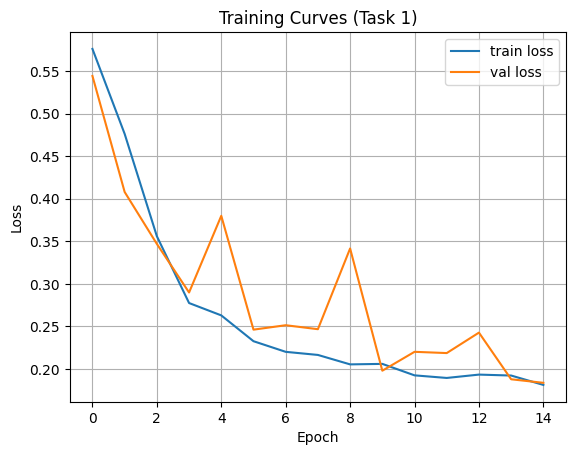

In [8]:
plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curves (Task 1)")
plt.legend()
plt.grid(True)
plt.show()

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns

# Load best model
model.load_state_dict(torch.load("best_model_task1.pt"))
model.eval()

all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.extend(probs)
        all_labels.extend(y.flatten())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Predictions
preds = (all_probs >= 0.5).astype(int)

# Metrics
acc = accuracy_score(all_labels, preds)
prec = precision_score(all_labels, preds)
rec = recall_score(all_labels, preds)
f1 = f1_score(all_labels, preds)
auc = roc_auc_score(all_labels, all_probs)

print("Accuracy :", acc)
print("Precision:", prec)
print("Recall   :", rec)
print("F1-score :", f1)
print("AUC      :", auc)

Accuracy : 0.8846153846153846
Precision: 0.8732394366197183
Recall   : 0.9538461538461539
F1-score : 0.9117647058823529
AUC      : 0.9458799035722113


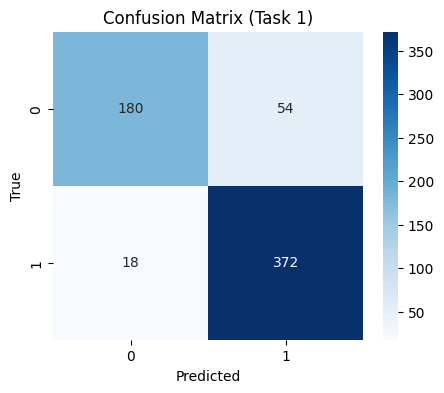

In [10]:
cm = confusion_matrix(all_labels, preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Task 1)")
plt.show()

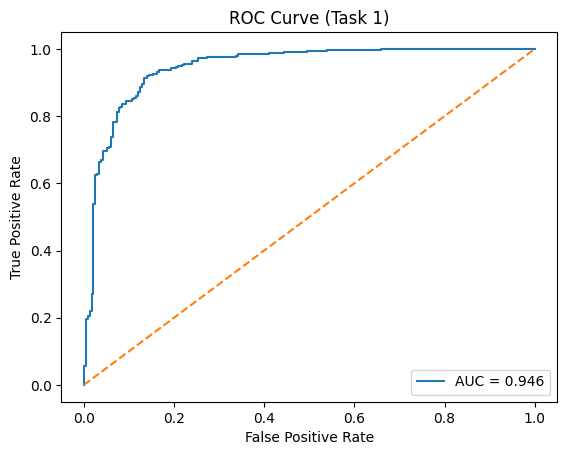

In [11]:
fpr, tpr, _ = roc_curve(all_labels, all_probs)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Task 1)")
plt.legend()
plt.show()

In [12]:
wrong_indices = np.where(preds != all_labels)[0]
len(wrong_indices)

72

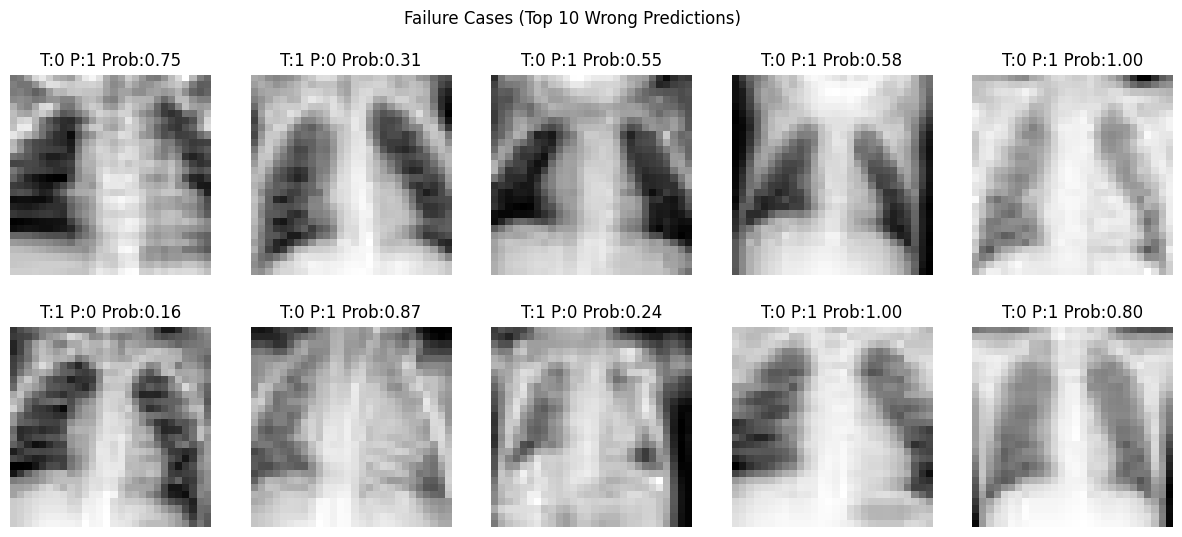

In [13]:
# Get original (non-augmented) test dataset for visualization
orig_test_ds = PneumoniaMNIST(split="test", download=True, transform=transforms.ToTensor())

plt.figure(figsize=(15,6))

for i in range(10):  # show 10 wrong cases
    idx = wrong_indices[i]
    img, label = orig_test_ds[idx]
    img = img.squeeze(0).numpy()

    prob = all_probs[idx]
    pred = preds[idx]

    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"T:{int(label[0])} P:{pred} Prob:{prob:.2f}")
    plt.axis("off")

plt.suptitle("Failure Cases (Top 10 Wrong Predictions)")
plt.show()

In [14]:
import os

os.makedirs("reports/task1", exist_ok=True)

# Save training curves
plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Curves (Task 1)")
plt.legend()
plt.grid(True)
plt.savefig("reports/task1/training_curves.png", dpi=300)
plt.close()

# Save confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Task 1)")
plt.savefig("reports/task1/confusion_matrix.png", dpi=300)
plt.close()

# Save ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Task 1)")
plt.legend()
plt.savefig("reports/task1/roc_curve.png", dpi=300)
plt.close()

print("All figures saved in reports/task1/")

All figures saved in reports/task1/


In [15]:
import json

metrics = {
    "accuracy": float(acc),
    "precision": float(prec),
    "recall": float(rec),
    "f1_score": float(f1),
    "auc": float(auc)
}

with open("reports/task1/test_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

metrics

{'accuracy': 0.8846153846153846,
 'precision': 0.8732394366197183,
 'recall': 0.9538461538461539,
 'f1_score': 0.9117647058823529,
 'auc': 0.9458799035722113}

In [16]:
plt.figure(figsize=(15,6))

for i in range(10):
    idx = wrong_indices[i]
    img, label = orig_test_ds[idx]
    img = img.squeeze(0).numpy()

    prob = all_probs[idx]
    pred = preds[idx]

    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"T:{int(label[0])} P:{pred} Prob:{prob:.2f}")
    plt.axis("off")

plt.suptitle("Failure Cases (Top 10 Wrong Predictions)")
plt.savefig("reports/task1/failure_cases.png", dpi=300)
plt.close()

print("Failure cases saved.")

Failure cases saved.


In [19]:
import os, shutil
os.makedirs("models", exist_ok=True)
shutil.copy("best_model_task1.pt", "models/best_model_task1.pt")
print("Saved models/best_model_task1.pt")

Saved models/best_model_task1.pt


In [20]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from medmnist import PneumoniaMNIST

orig_test_ds = PneumoniaMNIST(split="test", download=True, transform=transforms.ToTensor())

plt.figure(figsize=(15,6))
for i in range(10):
    idx = wrong_indices[i]
    img, label = orig_test_ds[idx]
    img = img.squeeze(0).numpy()
    prob = all_probs[idx]
    pred = preds[idx]
    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"T:{int(label[0])} P:{pred} Prob:{prob:.2f}")
    plt.axis("off")

plt.suptitle("Failure Cases (Top 10 Wrong Predictions)")
plt.savefig("reports/task1/failure_cases.png", dpi=300)
plt.close()
print("Saved reports/task1/failure_cases.png")

Saved reports/task1/failure_cases.png


In [22]:
import os
print(sorted(os.listdir("reports/task1")))

['confusion_matrix.png', 'failure_cases.png', 'roc_curve.png', 'test_metrics.json', 'training_curves.png']


In [23]:
import os
os.makedirs("reports/task2", exist_ok=True)
print("Created:", os.path.abspath("reports/task2"))

Created: /content/reports/task2


In [25]:
!git config --global user.name "Amna1701"
!git config --global user.email "2018024900@chd.edu.cn"

In [30]:
%cd /content
!git clone https://github.com/Amna1701/alfaisalx-medmnist-challenge.git
%cd alfaisalx-medmnist-challenge
!ls

/content
Cloning into 'alfaisalx-medmnist-challenge'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 91 (delta 35), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (91/91), 940.04 KiB | 15.67 MiB/s, done.
Resolving deltas: 100% (35/35), done.
/content/alfaisalx-medmnist-challenge
data  models  notebooks  README.md  reports  requirements.txt  task3_retrieval


In [32]:
%cd /content
!ls

/content
alfaisalx-medmnist-challenge  best_model_task1.pt  models  reports  sample_data


In [33]:
%cd /content/alfaisalx-medmnist-challenge
!ls -a

/content/alfaisalx-medmnist-challenge
.   data  .gitignore  notebooks  reports	   task3_retrieval
..  .git  models      README.md  requirements.txt


In [35]:
!git add .
!git status
!git commit -m "Add Task1 outputs (reports + model) and organize folders" || echo "Nothing to commit"

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Nothing to commit


In [38]:
%cd /content
!pwd
!ls -la

/content
/content
total 396
drwxr-xr-x 1 root root   4096 Feb 22 14:51 .
drwxr-xr-x 1 root root   4096 Feb 22 14:35 ..
drwxr-xr-x 8 root root   4096 Feb 22 14:51 alfaisalx-medmnist-challenge
-rw-r--r-- 1 root root 375179 Feb 22 14:41 best_model_task1.pt
drwxr-xr-x 4 root root   4096 Jan 16 14:24 .config
drwxr-xr-x 2 root root   4096 Feb 22 14:45 models
drwxr-xr-x 4 root root   4096 Feb 22 14:47 reports
drwxr-xr-x 1 root root   4096 Jan 16 14:24 sample_data


In [39]:
%cd /content
!rm -rf alfaisalx-medmnist-challenge
!git clone https://github.com/Amna1701/alfaisalx-medmnist-challenge.git
!ls

/content
Cloning into 'alfaisalx-medmnist-challenge'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 91 (delta 35), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (91/91), 940.04 KiB | 11.75 MiB/s, done.
Resolving deltas: 100% (35/35), done.
alfaisalx-medmnist-challenge  best_model_task1.pt  models  reports  sample_data


In [40]:
%cd /content/alfaisalx-medmnist-challenge
!ls -la

/content/alfaisalx-medmnist-challenge
total 48
drwxr-xr-x 8 root root 4096 Feb 22 15:01 .
drwxr-xr-x 1 root root 4096 Feb 22 15:01 ..
drwxr-xr-x 2 root root 4096 Feb 22 15:01 data
drwxr-xr-x 8 root root 4096 Feb 22 15:01 .git
-rw-r--r-- 1 root root 4688 Feb 22 15:01 .gitignore
drwxr-xr-x 2 root root 4096 Feb 22 15:01 models
drwxr-xr-x 2 root root 4096 Feb 22 15:01 notebooks
-rw-r--r-- 1 root root 1559 Feb 22 15:01 README.md
drwxr-xr-x 3 root root 4096 Feb 22 15:01 reports
-rw-r--r-- 1 root root   69 Feb 22 15:01 requirements.txt
drwxr-xr-x 2 root root 4096 Feb 22 15:01 task3_retrieval


In [41]:
%cd /content/alfaisalx-medmnist-challenge

!mkdir -p models reports
!cp -r /content/models/* models/ 2>/dev/null || echo "No /content/models found"
!cp -r /content/reports/* reports/ 2>/dev/null || echo "No /content/reports found"

!find reports -maxdepth 2 -type f
!find models -maxdepth 2 -type f

/content/alfaisalx-medmnist-challenge
reports/confusion_matrix.png
reports/task1_classification_report.md
reports/failure_cases.png
reports/task1/confusion_matrix.png
reports/task1/test_metrics.json
reports/task1/failure_cases.png
reports/task1/training_curves.png
reports/task1/roc_curve.png
reports/roc_curve.png
models/best_model_task1.pt


In [42]:
%cd /content/alfaisalx-medmnist-challenge
!git add -A
!git status
!git commit -m "Add Task1 outputs (reports + model)" || echo "Nothing to commit"

/content/alfaisalx-medmnist-challenge
On branch main
Your branch is up to date with 'origin/main'.

Changes to be committed:
  (use "git restore --staged <file>..." to unstage)
	modified:   models/best_model_task1.pt
	new file:   reports/task1/confusion_matrix.png
	new file:   reports/task1/failure_cases.png
	new file:   reports/task1/roc_curve.png
	new file:   reports/task1/test_metrics.json
	new file:   reports/task1/training_curves.png

[main 3d279fe] Add Task1 outputs (reports + model)
 6 files changed, 7 insertions(+)
 rewrite models/best_model_task1.pt (94%)
 create mode 100644 reports/task1/confusion_matrix.png
 create mode 100644 reports/task1/failure_cases.png
 create mode 100644 reports/task1/roc_curve.png
 create mode 100644 reports/task1/test_metrics.json
 create mode 100644 reports/task1/training_curves.png
